- Handling warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

- Load modules

In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import (silhouette_score, davies_bouldin_score, calinski_harabasz_score)
from sklearn.cluster import (KMeans, AffinityPropagation, AgglomerativeClustering, Birch, HDBSCAN,
                             BisectingKMeans, DBSCAN, MeanShift, MiniBatchKMeans, OPTICS, SpectralClustering)
import numpy as np
import json
from transformers import AutoTokenizer, AutoModel
import torch

- Defining auxiliar functions

In [3]:
def get_profile(row, label_columns):
    active_labels = [col for col in label_columns if row[col] == 1]
    return '-'.join(active_labels)

In [4]:
def estimated_metrics(dataset, labels, name_method):

    try:
        return {
            "name_method" : name_method,
            "silhouette_score" : silhouette_score(dataset, labels),
            "davies_bouldin_score" : davies_bouldin_score(dataset, labels),
            "calinski_harabasz_score" : calinski_harabasz_score(dataset, labels)}
    except:
        return {
            "name_method" : name_method,
            "silhouette_score" : np.nan,
            "davies_bouldin_score" : np.nan,
            "calinski_harabasz_score" : np.nan}

In [5]:
def apply_clustering(clustering_method, dataset, name_method, **kwargs):
    
    model = clustering_method(**kwargs)
    model.fit(dataset)
    metrics = estimated_metrics(dataset, model.labels_, name_method)

    return model, metrics

- Loading and preparing data for word/sentence clustering

In [6]:
df_data = pd.read_csv("curated_PrimaryOdor.csv")
df_data.head(5)

,standardized_smiles,odor_2,odor_3,odor_4,odor_5,odor_6,odor_7,odor_8,odor_9,odor_10,...,odor_28,odor_29,odor_30,odor_31,odor_32,odor_33,odor_34,odor_35,odor_36,odor_37
0,BrC=Cc1ccccc1,Fragrant,Vegetation,Green,Fruity,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C#CC(C)(O)CCC=C(C)C,Dry,Ambrosial,Woody,Waxy,Resinous,Grassy,Sweet,Fragrant,Plants,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C#CC1(OC(C)=O)CCCCC1,Dry,Vegetation,Aromatic,Woody,Nutty,Resinous,Grassy,Other,Fragrant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C#CC1(OC(C)=O)CCCCC1C(C)CC,Dry,Vegetation,Woody,Soft oriental,Resinous,Grassy,Mossy woods,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C#CCO,Fragrant,Floral,Nature,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_data.columns

Index(['standardized_smiles', 'odor_2', 'odor_3', 'odor_4', 'odor_5', 'odor_6',
       'odor_7', 'odor_8', 'odor_9', 'odor_10', 'odor_11', 'odor_12',
       'odor_13', 'odor_14', 'odor_15', 'odor_16', 'odor_17', 'odor_18',
       'odor_19', 'odor_20', 'odor_21', 'odor_22', 'odor_23', 'odor_24',
       'odor_25', 'odor_26', 'odor_27', 'odor_28', 'odor_29', 'odor_30',
       'odor_31', 'odor_32', 'odor_33', 'odor_34', 'odor_35', 'odor_36',
       'odor_37'],
      dtype='object')

- Get Unique odors

In [8]:
list_unique_odors = []

for i in range(2, 38):
    column = f"odor_{i}"
    unique_values = df_data[column].unique().tolist()
    unique_values = [str(value).replace(" ", "_").lower() for value in unique_values]
    list_unique_odors += unique_values

list_unique_odors = list(set(list_unique_odors))
len(list_unique_odors)

114

- Loading pre-trained model from sentenceTransformer: See https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2 for more details

In [9]:
model = SentenceTransformer('all-MiniLM-L6-v2')

- Get embeddings for applying clustering strategies

In [10]:
matrix_for_clustering = []
list_words_for_clustering = []

for word in list_unique_odors:
    if str(word) != "nan":
        vector = model.encode(word)
        matrix_for_clustering.append(vector)
        list_words_for_clustering.append(word)

header = [f"p_{i+1}" for i in range(len(matrix_for_clustering[0]))]
df_for_clustering = pd.DataFrame(data=matrix_for_clustering, columns=header)
df_for_clustering['word'] = list_words_for_clustering
df_for_clustering

,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,...,p_376,p_377,p_378,p_379,p_380,p_381,p_382,p_383,p_384,word
0,-0.059216,-0.008239,-0.023287,0.001872,0.009974,0.020406,0.144943,0.022790,0.057856,-0.060984,...,-0.015772,-0.010042,0.083261,0.013299,-0.105452,0.090167,0.042404,0.076830,0.051472,aromatic
1,-0.088877,-0.012907,-0.018166,0.022641,0.043929,0.020505,0.026107,0.067556,0.029861,0.000681,...,-0.029735,-0.002579,0.026314,-0.052159,0.009949,0.112131,-0.041559,0.023663,0.052179,raw
2,-0.072107,0.081733,-0.039282,0.083651,-0.017182,-0.005012,0.198541,0.053228,-0.013378,-0.018187,...,0.065776,-0.030717,0.026081,-0.044640,0.018320,0.077594,-0.037749,0.006687,0.032904,metallic
3,-0.094550,0.001347,0.013085,0.006473,-0.106424,-0.024775,0.098671,0.018099,-0.003125,-0.044895,...,0.040271,0.104385,-0.046731,-0.013035,0.032674,0.099561,-0.079499,-0.054718,0.047609,sulp
4,0.055517,0.011074,0.042071,-0.034621,-0.017324,0.000263,0.040797,0.044179,-0.013758,0.058859,...,-0.040299,0.017136,0.029541,0.012260,0.042473,0.015203,-0.010469,-0.069202,-0.034668,nutty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,-0.013489,0.036412,0.015775,0.092194,-0.055615,0.047724,0.159104,-0.092966,0.009969,-0.019044,...,-0.016255,0.024746,0.032530,0.015018,0.033882,0.047883,0.021746,0.049941,-0.001797,food
109,-0.010588,0.028556,-0.040009,0.011094,0.021317,-0.027946,0.140699,-0.068097,0.034152,0.018650,...,-0.002347,0.096055,0.012977,-0.061696,-0.013658,0.078145,-0.076249,-0.009978,0.000097,brown
110,-0.040850,-0.032689,0.033048,-0.009111,-0.049081,-0.022154,0.156250,0.035108,0.056392,-0.048354,...,0.029317,0.028213,-0.014652,-0.040823,0.034688,0.120027,0.064855,-0.046813,0.048345,salty
111,-0.027596,-0.017387,-0.032880,0.027000,0.019340,0.025731,0.194508,0.012574,0.021884,-0.037260,...,-0.015297,-0.026099,0.003627,-0.078352,-0.045624,0.112355,0.011337,0.117996,-0.047902,beverage


- Loading hyperparameter config for clustering

In [11]:
with open('hyperparameter_unsupervised_methods.json', 'r') as config:
    hyperparameter_configs = json.load(config)

- Applying clustering algorithms

In [12]:
list_configs = [
    (AgglomerativeClustering, "AgglomerativeClustering", hyperparameter_configs['AgglomerativeClustering']),
    (HDBSCAN, "HDBSCAN", hyperparameter_configs['HDBSCAN']),
    (OPTICS, "OPTICS", hyperparameter_configs['OPTICS']),
    (SpectralClustering, "SpectralClustering", hyperparameter_configs['SpectralClustering']),
    (MeanShift, "MeanShift", hyperparameter_configs['MeanShift']),
    (BisectingKMeans, "BisectingKMeans", hyperparameter_configs['BisectingKMeans']),
    (Birch, "Birch", hyperparameter_configs['Birch']),
    (KMeans, "Kmeans", hyperparameter_configs['Kmeans']),
    (DBSCAN, "DBSCAN", hyperparameter_configs['DBSCAN']),
    (AffinityPropagation, "AffinityPropagation", hyperparameter_configs['AffinityPropagation']),
]

In [13]:
list_models = {}
list_performances = []

for config_values in list_configs:
    model, performances = apply_clustering(
        config_values[0], 
        df_for_clustering.drop(columns=['word']), 
        config_values[1], 
        **config_values[2])
    
    list_models.update({config_values[1]: model})
    list_performances.append(performances)

performance_algorithms = pd.DataFrame(list_performances)
performance_algorithms

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

,name_method,silhouette_score,davies_bouldin_score,calinski_harabasz_score
0,AgglomerativeClustering,0.032275,3.245384,3.110125
1,HDBSCAN,NaN,NaN,NaN
2,OPTICS,-0.020073,2.545560,2.079049
3,SpectralClustering,0.035981,3.085241,3.256517
4,MeanShift,NaN,NaN,NaN
5,BisectingKMeans,0.011024,3.592106,2.318089
6,Birch,0.011930,3.436087,3.131989
7,Kmeans,0.026254,3.418186,2.743216
8,DBSCAN,NaN,NaN,NaN
9,AffinityPropagation,0.046436,2.493189,2.596549


In [14]:
performance_algorithms.sort_values(by="silhouette_score", ascending=False)

,name_method,silhouette_score,davies_bouldin_score,calinski_harabasz_score
9,AffinityPropagation,0.046436,2.493189,2.596549
3,SpectralClustering,0.035981,3.085241,3.256517
0,AgglomerativeClustering,0.032275,3.245384,3.110125
7,Kmeans,0.026254,3.418186,2.743216
6,Birch,0.011930,3.436087,3.131989
5,BisectingKMeans,0.011024,3.592106,2.318089
2,OPTICS,-0.020073,2.545560,2.079049
1,HDBSCAN,NaN,NaN,NaN
4,MeanShift,NaN,NaN,NaN
8,DBSCAN,NaN,NaN,NaN


In [15]:
pd.Series(list_models['SpectralClustering'].labels_).value_counts()

6    21
2    20
0    17
3    16
4    13
7    12
1    11
5     3
Name: count, dtype: int64

- Apply dimensionality reduction techniques and make visualization

In [16]:
data_transformed = TSNE(random_state=42).fit_transform(df_for_clustering.drop(columns=['word']))
df_tsne = pd.DataFrame(data=data_transformed, columns=["t-SNE 1", "t-SNE 2"])
df_tsne['cluster'] = list_models['SpectralClustering'].labels_
df_tsne['cluster'] = df_tsne['cluster'].astype(str)

<Axes: xlabel='t-SNE 1', ylabel='t-SNE 2'>

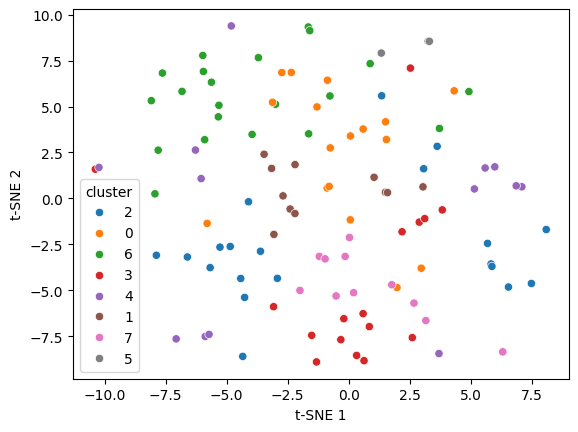

In [17]:
sns.scatterplot(data=df_tsne, x="t-SNE 1", y="t-SNE 2", hue="cluster")

- Checking the content per clustering

In [18]:
useful_columns = []
for element in list_models:
    if element not in ['HDBSCAN', 'MeanShift', 'DBSCAN', 'OPTICS']:
        df_for_clustering[element] = list_models[element].labels_
        useful_columns.append(element)

In [19]:
df_for_clustering

,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,...,p_382,p_383,p_384,word,AgglomerativeClustering,SpectralClustering,BisectingKMeans,Birch,Kmeans,AffinityPropagation
0,-0.059216,-0.008239,-0.023287,0.001872,0.009974,0.020406,0.144943,0.022790,0.057856,-0.060984,...,0.042404,0.076830,0.051472,aromatic,4,2,3,0,1,13
1,-0.088877,-0.012907,-0.018166,0.022641,0.043929,0.020505,0.026107,0.067556,0.029861,0.000681,...,-0.041559,0.023663,0.052179,raw,1,0,5,0,4,2
2,-0.072107,0.081733,-0.039282,0.083651,-0.017182,-0.005012,0.198541,0.053228,-0.013378,-0.018187,...,-0.037749,0.006687,0.032904,metallic,1,0,7,0,1,13
3,-0.094550,0.001347,0.013085,0.006473,-0.106424,-0.024775,0.098671,0.018099,-0.003125,-0.044895,...,-0.079499,-0.054718,0.047609,sulp,2,2,7,0,1,3
4,0.055517,0.011074,0.042071,-0.034621,-0.017324,0.000263,0.040797,0.044179,-0.013758,0.058859,...,-0.010469,-0.069202,-0.034668,nutty,5,6,1,2,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,-0.013489,0.036412,0.015775,0.092194,-0.055615,0.047724,0.159104,-0.092966,0.009969,-0.019044,...,0.021746,0.049941,-0.001797,food,3,3,5,1,3,14
109,-0.010588,0.028556,-0.040009,0.011094,0.021317,-0.027946,0.140699,-0.068097,0.034152,0.018650,...,-0.076249,-0.009978,0.000097,brown,1,0,0,0,4,6
110,-0.040850,-0.032689,0.033048,-0.009111,-0.049081,-0.022154,0.156250,0.035108,0.056392,-0.048354,...,0.064855,-0.046813,0.048345,salty,1,0,1,0,4,0
111,-0.027596,-0.017387,-0.032880,0.027000,0.019340,0.025731,0.194508,0.012574,0.021884,-0.037260,...,0.011337,0.117996,-0.047902,beverage,4,7,5,0,5,15


In [20]:
dict_with_words = []

for column in useful_columns:
    labels = df_for_clustering[column].unique()
    list_words = []
    for label in labels:
        words = df_for_clustering[df_for_clustering[column] == label]['word'].tolist()
        words = ', '.join(words)
        dict_value = {"label": str(label), "words": words}
        list_words.append(dict_value)
    dict_cluster = {
        "cluster":column,
        "number_of_labels":int(len(labels)),
        "content" : list_words
    }
    dict_with_words.append(dict_cluster)

with open("summary_word_clustering.json", "w", encoding="utf-8") as f:
    json.dump(dict_with_words, f, indent=4, ensure_ascii=False)

- Next step: Exploring relation of clusters per compound. We will select just an option of the generated clusters and then we will apply the methodology.

In [21]:
df_for_clustering

,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,...,p_382,p_383,p_384,word,AgglomerativeClustering,SpectralClustering,BisectingKMeans,Birch,Kmeans,AffinityPropagation
0,-0.059216,-0.008239,-0.023287,0.001872,0.009974,0.020406,0.144943,0.022790,0.057856,-0.060984,...,0.042404,0.076830,0.051472,aromatic,4,2,3,0,1,13
1,-0.088877,-0.012907,-0.018166,0.022641,0.043929,0.020505,0.026107,0.067556,0.029861,0.000681,...,-0.041559,0.023663,0.052179,raw,1,0,5,0,4,2
2,-0.072107,0.081733,-0.039282,0.083651,-0.017182,-0.005012,0.198541,0.053228,-0.013378,-0.018187,...,-0.037749,0.006687,0.032904,metallic,1,0,7,0,1,13
3,-0.094550,0.001347,0.013085,0.006473,-0.106424,-0.024775,0.098671,0.018099,-0.003125,-0.044895,...,-0.079499,-0.054718,0.047609,sulp,2,2,7,0,1,3
4,0.055517,0.011074,0.042071,-0.034621,-0.017324,0.000263,0.040797,0.044179,-0.013758,0.058859,...,-0.010469,-0.069202,-0.034668,nutty,5,6,1,2,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,-0.013489,0.036412,0.015775,0.092194,-0.055615,0.047724,0.159104,-0.092966,0.009969,-0.019044,...,0.021746,0.049941,-0.001797,food,3,3,5,1,3,14
109,-0.010588,0.028556,-0.040009,0.011094,0.021317,-0.027946,0.140699,-0.068097,0.034152,0.018650,...,-0.076249,-0.009978,0.000097,brown,1,0,0,0,4,6
110,-0.040850,-0.032689,0.033048,-0.009111,-0.049081,-0.022154,0.156250,0.035108,0.056392,-0.048354,...,0.064855,-0.046813,0.048345,salty,1,0,1,0,4,0
111,-0.027596,-0.017387,-0.032880,0.027000,0.019340,0.025731,0.194508,0.012574,0.021884,-0.037260,...,0.011337,0.117996,-0.047902,beverage,4,7,5,0,5,15


In [22]:
df_filter = df_for_clustering[['word', 'SpectralClustering']]
df_filter["SpectralClustering"].value_counts().sort_index()

SpectralClustering
0    17
1    11
2    20
3    16
4    13
5     3
6    21
7    12
Name: count, dtype: int64

In [23]:
matrix_data_pivote = []

for index in df_data.index:
    smile = [df_data["standardized_smiles"][index]]

    row_odor = [0 for i in range(len(df_filter["SpectralClustering"].unique()))]

    odor_list = [df_data[column][index].replace(" ", "_").lower() for column in df_data.columns if column != "standardized_smiles" and str(df_data[column][index]) != "nan"]
    
    for word in odor_list:
        filter_cluster_values = df_filter[df_filter["word"] == word]
        filter_cluster_values.reset_index(inplace=True)
        cluster_id = int(filter_cluster_values["SpectralClustering"][0])
        row_odor[cluster_id] = 1
    
    row = smile + row_odor
    matrix_data_pivote.append(row)

header_clusters = [f"label_{i}" for i in range(len(df_filter["SpectralClustering"].unique()))]
header_clusters.insert(0, "standardized_smiles")

df_pivote = pd.DataFrame(data=matrix_data_pivote, columns=header_clusters)
df_pivote

,standardized_smiles,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7
0,BrC=Cc1ccccc1,1,1,0,1,0,0,0,0
1,C#CC(C)(O)CCC=C(C)C,1,1,1,1,1,0,1,0
2,C#CC1(OC(C)=O)CCCCC1,1,1,1,1,1,0,1,0
3,C#CC1(OC(C)=O)CCCCC1C(C)CC,1,0,1,1,1,0,0,0
4,C#CCO,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
3419,c1coc(Cc2coc(Cc3ccco3)c2)c1,0,1,0,1,0,0,1,0
3420,c1coc(Cn2cccc2)c1,1,1,1,1,1,0,1,1
3421,c1csc(SSc2cccs2)c1,1,0,1,0,1,1,1,1
3422,c1cscn1,1,0,1,1,0,0,1,1


In [24]:
df_pivote["number_of_profiles"] = df_pivote.sum(numeric_only=True, axis=1)
df_pivote

,standardized_smiles,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,number_of_profiles
0,BrC=Cc1ccccc1,1,1,0,1,0,0,0,0,3
1,C#CC(C)(O)CCC=C(C)C,1,1,1,1,1,0,1,0,6
2,C#CC1(OC(C)=O)CCCCC1,1,1,1,1,1,0,1,0,6
3,C#CC1(OC(C)=O)CCCCC1C(C)CC,1,0,1,1,1,0,0,0,4
4,C#CCO,0,1,0,1,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...
3419,c1coc(Cc2coc(Cc3ccco3)c2)c1,0,1,0,1,0,0,1,0,3
3420,c1coc(Cn2cccc2)c1,1,1,1,1,1,0,1,1,7
3421,c1csc(SSc2cccs2)c1,1,0,1,0,1,1,1,1,6
3422,c1cscn1,1,0,1,1,0,0,1,1,5


In [25]:
df_pivote.to_csv("pivote_dataset.csv", index=False)